# 2023 
## Di Marzo Gabriele
## Git-merge, weight matching for interpolate mlp 

Empirical evidence shows that merging N models just with the average of each returns a model with a useless result. A second strategy is averaging the output of each model, but this means that we need to keep in memory all the N models and make them run in parallel. 

[Entezari et al. (2021)](https://arxiv.org/abs/2110.06296) conjecture that if permutation invariance is taken into account, then all SGD solutions for a sufficiently wide network trained on the same task become linearly mode connected, i.e., have
no barrier between them. 

Simply put: we can train models with the same architecture (even on different datasets), permute the weight matrices, interpolate the weight of each matrix, and get a model with the same performance.

<h3> Some useful definition :</h3>

<b>barrier</b>: The loss barrier $B(\Theta_A, \Theta_B)$ along the linear path between $\Theta_A$ and $\Theta_A$ is defined as the highest
difference between the loss occurred when linearly connecting two points $\Theta_A$, $\Theta_B$ and linear interpolation of the
loss values in each of them 

<b>LinearModelConnectivity (LMC)</b>: We say that two networks $\Theta_A$ and $\Theta_B$ are lineary mode connected if the barrier between them along a linear path is $≈$ 0 


<h2><b>Main problem, how permute the model for get this property?</b></h2>


# This notebook: 
The method that this notebook implements comes from 
[Ainsworth 2022](https://arxiv.org/abs/2209.04836) where some algorithms that allows linear interpolation between models with the same architecture is presented. All the work done is based on the conjecture of Entezari about permutation invariance. 

The paper present 3 method:
- activation matching
- weight matchin
- straight-through estimator


Although the last method shows better results (as loss), it's also the most power-consuming, and considering that the difference between the last and the first method is not so huge, the authors agree that the second is the best option for a fast merging. For these reasons, the notebook that i present shows a possible implementation of the weight matching procedure.
\
\
Thanks to these methods, it's possible to think about a system made of several small models and merge the contributions of each network, without increasing the loss of the model. 

### fine tuning : better exploration of loss landscape
Just as note, the question that the paper tries to address is why the SGD solution works well in some problems but is less robust in other optimization settings. Keep reading the paper, i didn't find a answer to this question. Indeed it seems that the paper is more focused on explaining the different merging procedures. 

Reading online (Twitter, with the huge community of NN students) it turns out that the permuted weights are linearly connected to the other network if the learning rate is sufficiently <font color="red"><b>high</b></font>
and you use <font color="red"><b>SGD</b></font>, or the learning rate is sufficiently <font color="blue"><b>low</b></font> and you use the <font color="blue"><b>Adam optimizer</b></font>.
\
In my experiment i keep using the default learning rate, also because I discovered these details after a few attempts. In any case, the merging procedure still works.

A reference for this particular details: [Stanislav Fort github](https://github.com/stanislavfort/dissect-git-re-basin), see latest update of the readme 

# Import lib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch import autocast
from torch.cuda.amp import GradScaler 

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize


import copy
import pickle
import random
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from collections import defaultdict
from google.colab import files
from itertools import chain
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# insert path of the folder where there is the dir *models*

path = 'TODO'

# Dataset and Dataloader
For testing the algorithm, I chose to use 3 well known datasets: the Mnist dataset, the FashionMnist dataset and the cifar10 dataset. All the dataset comes from torch vision.

In [ ]:
%%capture 
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data_F = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data_F = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data_CIFAR = datasets.CIFAR10(
    root='data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
)

test_data_CIFAR = datasets.CIFAR10(
    root='data', 
    train=False, 
    download=True, 
    transform=transforms.Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
)


In [ ]:
experiment_data = {}
experiment_data['MNIST'] = {'train':training_data, 'test': test_data}
experiment_data['FMNIST'] = {'train':training_data_F, 'test': test_data_F}
experiment_data['CIFAR10'] = {'train': training_data_CIFAR, 'test': training_data_CIFAR}

data_loaders = {
    'mnist':{
        'train': DataLoader(experiment_data['MNIST']['train'], batch_size=124, shuffle=True),
        'test' : DataLoader(experiment_data['MNIST']['test'], batch_size=124)
    },
    'fashion':{
        'train': DataLoader(experiment_data['FMNIST']['train'], batch_size=124, shuffle=True), 
        'test' : DataLoader(experiment_data['FMNIST']['test'], batch_size=124)
    }, 
    'cifar':{
        'train': DataLoader(experiment_data['CIFAR10']['train'], batch_size=124, shuffle=True),
        'test' : DataLoader(experiment_data['CIFAR10']['test'], batch_size=124)
    }
}

mnist_input_size = 28*28    # W * H
cifar_input_size = 3*32*32  # Channels * W * H

MNIST || label: 4, number of sample in the dataset: 60000


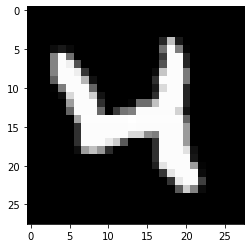

In [ ]:
img, lab = experiment_data['MNIST']['train'][20]
img = np.array(img, dtype='float').reshape(28, 28)
plt.imshow(img, cmap='gray')
print(f"MNIST || label: {lab}, number of sample in the dataset: {len(experiment_data['MNIST']['train'])}")

F_MNIST|| label: T-shirt/top, number of sample in the dataset: 60000


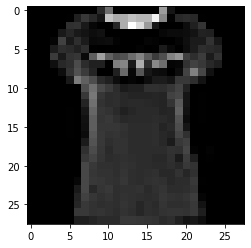

In [ ]:
fashion_mnist_label_mapping = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, lab = experiment_data['FMNIST']['train'][34]
img = np.array(img, dtype='float').reshape(28, 28)
plt.imshow(img, cmap='gray')
print(f"F_MNIST|| label: {fashion_mnist_label_mapping[lab]}, number of sample in the dataset: {len(experiment_data['MNIST']['train'])}")

CIFAR || label: car, number of sample in the dataset: 60000


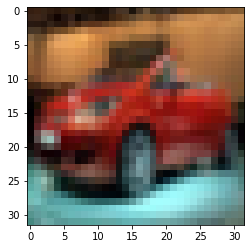

In [ ]:
cifar_label_mapping = ('plane', 'car', 'bird', 'cat',
                       'deer', 'dog', 'frog', 'horse',
                       'ship', 'truck')

img, lab = experiment_data['CIFAR10']['train'][45]
img = img / 2 + 0.5
img = np.transpose(img.numpy(), (1,2,0))
plt.imshow(img)
print(f"CIFAR || label: {cifar_label_mapping[lab]}, number of sample in the dataset: {len(experiment_data['MNIST']['train'])}")

# Models definition & utility 
Model classes, utility for dict of parameters, train etc.

The models that i choose are 3, pretty similar, the only difference between them is the number of parameters for layer and the number of layers. 
\
[Entezari (2.2)](https://arxiv.org/pdf/2110.06296.pdf#subsection.2.2) explains that different architectures responde in a different way to the permutation conjecture. This behaviour will be evaluate in the [experiements part](#scrollTo=CxLWE5El9rZM&line=1&uniqifier=1)
of this notebook.

In [ ]:
class SNet(nn.Module): 

  def __init__(self, input_size, bias=True): 
    super(SNet, self).__init__()
    self.dense1 = torch.nn.Linear(input_size, 50, bias=bias)
    self.dense2 = torch.nn.Linear(50, 40, bias=bias)
    self.dense3 = torch.nn.Linear(40, 30, bias=bias)
    self.dense4 = torch.nn.Linear(30, 10, bias=bias)

  def forward(self, x): 
    x = torch.flatten(x, start_dim=1)
    x = torch.nn.functional.relu(self.dense1(x))
    x = torch.nn.functional.relu(self.dense2(x))
    x = torch.nn.functional.relu(self.dense3(x))
    return self.dense4(x)

In [ ]:
class MNet(nn.Module): 
  def __init__(self, input_size, bias=True): 
    super(MNet, self).__init__()
    self.dense1 = torch.nn.Linear(input_size, 512, bias=bias)
    self.dense2 = torch.nn.Linear(512, 512, bias=bias)
    self.dense3 = torch.nn.Linear(512, 512, bias=bias)
    self.dense4 = torch.nn.Linear(512, 10, bias=bias)

  def forward(self, x): 
    x = torch.flatten(x, start_dim=1)
    x = torch.nn.functional.relu(self.dense1(x))
    x = torch.nn.functional.relu(self.dense2(x))
    x = torch.nn.functional.relu(self.dense3(x))
    return self.dense4(x)

In [ ]:
class DNet(nn.Module): 
  def __init__(self, input_size, bias=True): 
    super(DNet, self).__init__()
    self.dense1 = torch.nn.Linear(input_size,256, bias=bias)
    self.dense2 = torch.nn.Linear(256, 256, bias=bias)
    self.dense3 = torch.nn.Linear(256, 128, bias=bias)
    self.dense4 = torch.nn.Linear(128, 128, bias=bias)
    self.dense5 = torch.nn.Linear(128, 128, bias=bias)
    self.dense6 = torch.nn.Linear(128, 64, bias=bias)
    self.dense7 = torch.nn.Linear(64, 32, bias=bias)
    self.dense8 = torch.nn.Linear(32, 10, bias=bias)

  def forward(self, x): 
    x = torch.flatten(x, start_dim=1)
    x = torch.nn.functional.relu(self.dense1(x))
    x = torch.nn.functional.relu(self.dense2(x))
    x = torch.nn.functional.relu(self.dense3(x))
    x = torch.nn.functional.relu(self.dense4(x))
    x = torch.nn.functional.relu(self.dense5(x))
    x = torch.nn.functional.relu(self.dense6(x))
    x = torch.nn.functional.relu(self.dense7(x))
    return torch.nn.functional.relu(self.dense8(x))


<h3>Small note:</h3>

The training procedure uses the AutonomusMixedPrecision, a technique that I'd like to test for training. It's not relevant to the scope of the permutation selection, but should increase the velocity of training.

In [ ]:
#@title train utility
def train_loop(data_loader, model,
               loss_fn, optimizer, 
               scaler,
               print_score=True, return_loss=False): 

  size = len(data_loader.dataset)
  losses = []
  for batch, (x, y) in enumerate(data_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    with autocast(device_type='cuda', dtype=torch.float16):
      pred = model(x)
      loss = loss_fn(pred, y)

    
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    losses.append(loss.item())

  if print_score: 
    print('\tEpoch loss: ', sum(losses)/len(losses) )
  if return_loss: 
    return sum(losses)/len(losses)


def test_loop(data_loader_dict, model, loss_fn, device, test_set=True, print_score=True): 
  set_ = 'test' if test_set else 'train'
  data_loader = data_loader_dict[set_]
  size = len(data_loader.dataset)
  num_batches = len(data_loader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  if not print_score: 
    return 100*correct, test_loss
  
  print(f"Eval on {set_}: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
   

In [ ]:
#@title detach & retach
'''function for convert raw dict of parameters (numpy) to torch parameters and vice-versa'''

def detach_parameters(params): 
  return {k: v.cpu().detach().numpy() for k, v in params.items()}

def retach_parameters(params): 
  return {k: torch.from_numpy(v).to(device) for k, v in params.items()}


# Permutation utility 
 


In [ ]:
#@title matrix2index & index2matrix
'''
utility for convert a permutation matrix to the index version and vice-versa.
Used to work with the implementation of Linear Sum Assingment in scipy. 
One could also work with only the index version, which in a real application 
can be more efficient, but I thought that for an experimental
notebook (like this one) the matrix version would be easier to understand.
'''
def matrix2index(P, axis='col'):
  index = {}
  if axis == 'row':
    return None
  if axis == 'col':
    for i in range(P.shape[0]):
      index[i] = np.argmax(P[i])
    
    reverse_index = {v:k for k, v in index.items()}
  
    return [reverse_index[i] for i in range(len(reverse_index))]


def index2matrix(index, axis='col'):
  len_id = len(index)
  matrix = np.zeros((len_id, len_id))
  temp_id = {i: index[i] for i in range(len(index))}
  for i in range(len_id): 
    matrix[temp_id[i], i] = 1 
  
  return matrix

In [ ]:
#@title interpolation utility
def interpolate_2_models(coef:float, vector1:dict ,vector2:dict):
  '''return list of interpolate models, for testing the interpolation with different parameters'''
  assert (coef>=0.0 and coef<=1.0), f'coef val : {coef}'
  coef1 = 1-coef
  coef2 = coef
  return dict(
      [(key, coef1*vector1[key] + coef2*vector2[key] ) for key in vector1.keys()]
  )


In [ ]:
#@title plot_barrier
def plot_barrier(eval_interpolated, eval_interpolated_permuted, coef_vector, title):

  train_losses, test_losses = eval_interpolated['train'], eval_interpolated['test']
  train_losses_p, test_losses_p = eval_interpolated_permuted['train'], eval_interpolated_permuted['test']

  limit_up = max(chain(train_losses, test_losses, train_losses_p, test_losses_p))
  limit_down = min(chain(train_losses, test_losses, train_losses_p, test_losses_p))
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle(title, fontsize=20)
  
  ax1.set_title('original model')
  ax1.plot(coef_vector, train_losses, '--', label='train', marker='o', color='crimson')
  ax1.plot(coef_vector, test_losses,label='test', marker='o', color='navy')
  ax1.set_xlabel('interpolation coeff', fontsize=16)
  ax1.set_ylabel('loss', fontsize=16)
  ax1.set_ylim([limit_down-0.5, limit_up+0.5])
  ax1.legend(fontsize=16)

  ax2.set_title('permuted model')
  ax2.plot(coef_vector, train_losses_p, '--', label='train', marker='o', color='crimson')
  ax2.plot(coef_vector, test_losses_p, label='test', marker='o', color='navy')
  ax2.set_xlabel('interpolation coeff', fontsize=16)
  ax2.set_ylabel('loss', fontsize=16)
  ax2.set_ylim([limit_down-0.5, limit_up+0.5])
  ax2.legend(fontsize=16)


  plt.show()


In [ ]:
#@title evaluate interpolation 
def evaluate_interpolation(data_loaders,
                           loss_fn,
                           model_A,
                           model_B,
                           coef_vect,
                           device,                          
                           ):
  '''
  calc test/train loss and accuracy for a set of interpolated models. 
  (consider that there is no restrinction over the kind of model, 
  can be the permuted ones or the original)
  
  '''
  test_losses_list = []
  train_losses_list = []
  params_A = detach_parameters(dict(model_A.named_parameters()))
  params_B = detach_parameters(dict(model_B.named_parameters()))

  print('index | coef | test loss | test_acc')    

  for index, coef in enumerate(coef_vector): 

    interpolated_model = copy.deepcopy(model_A)
    interpolated_model.to(device)
    
    params = interpolate_2_models(coef, params_A, params_B)
    interpolated_model.load_state_dict(retach_parameters(params))

    test_acc, test_loss = test_loop(data_loaders, interpolated_model,
                                    loss_fn, device=device,
                                    test_set=True, print_score=False)
    _, train_loss = test_loop(data_loaders, interpolated_model,
                              loss_fn, device=device, 
                              test_set=False, print_score=False)

    test_losses_list.append(test_loss)
    train_losses_list.append(train_loss)
    print(f'   {index}  | {coef:.2f} |   {test_loss:.4f}  | {test_acc:.3f}')
  return {'train': train_losses_list, 'test': test_losses_list} 


## Permutation calc:  weight_matching & utils

The weight matching is the main algorithm of this notebook. The idea is to find a set of permutations that maximize the similarity between 2 models. Considering the huge number of permutation matrixes, it's impossible to run exhaustive research over all the parameters. 

Entezari proposed to use a local search alg. like the simulated annealing, the reference paper prefers look for a different approach.
\
\
Indeed, they tried to find a set of permutation matrix $\pi$ that satisfies the following optimization problem:
\
\
\begin{equation}
  argmin_\pi|| vec(\Theta_A) - vec(\pi(\Theta_B) ||^2
\end{equation}
\
where the $vec$ function return a "vectorize" version of the model parameters $\Theta_A$ and $\Theta_B$. 

Developing the solution of the optimization problem for all the layers, we get a SOBLAB (sum of bilinear assignments problem), which is NP-hard and does not have a polynomial time solution. 
\
The solution for this became searching just for one permutation for step, keeping the other fixed, selecting the best in a greedy way, and iterating the algorithm until convergence (no increase in similarity).

In this way, the SOBLAB became a LAP (linear assignments problem):
\
\
\begin{equation}
    argmax_{\pi=\{P_i\}} <W_l^{A}, P_l W_l^{B} P_{l-1}^T>_F +  <W_{l+1}^{A}, P_{l+1} W_{l+1}^{B} P_{l}^T>_F
\end{equation}
\
Where the subscrip F indicates the frobenius norm

From this optimization problem, the paper develops this solution:
\
\
\begin{equation}
    argmax_{\pi=\{P_i\}} <P_l, W_l^A P_{l-1} W_l^{BT}  + W_{l+1}^{AT} P_{l+1} W_{l+1}^B >_F
\end{equation}
\
Unfortunately, applying this solution the algorithm is unable to converge to a solution. 
In [this cell](#scrollTo=emjIFlkiZZ6v) it's possible to see the effect of using the equation from the paper for a max of 100 iterations.The similarity level for all the layers never goes to 0 (as it should).
\
\
I'd like to underline that the paper declares clearly that <b>they do not use the solution proposed in the paper</b>, but a different implementation (not presented).
\
Also, the presented solution is expressed in simple terms (mlp, without bias), and there is no reference to extending the method to a cnn network or adding a bias term.  

So, after some time, i developed my "personal" close form solution for the optimization problem: 
\
\
\begin{equation}
    argmax_{\pi=\{P_i\}} <P_l, W_l^B P_{l-1}^T W_l^{AT}  + W_{l+1}^{BT} P_{l+1}^T W_{l+1}^A >_F
\end{equation}
\
I have also added the contribution of the bias term, to obtain this solution:
\
\
\begin{equation}
    argmax_{\pi=\{P_i\}} <P_l,  W_l^B P_{l-1}^T W_l^{AT}  + W_{l+1}^{BT} P_{l+1}^T W_{l+1}^A + b^{AT}_l b^{B}_l>_F 
\end{equation}
\
I'd also like to report that any reproduction of the paper code that i found online uses the same base code of the original code, with an easy copy-paste from the main repository. All these projects are just checking the procedure for a new mlp model. It was not possible to find an original implementation or just a test with a non-dense architecture.


In [ ]:
def weight_matching(A_funct, P, runs=100, silent=False): 

  for run in range(runs): 
    progress = False
    for j in np.random.permutation(list(range(1, len(P)+1))): 
      A = A_funct[f'A{j}'](P)
    

      row_index, col_index = linear_sum_assignment(A, maximize=True)

      p_index = matrix2index(P[f'P{j}'])
      old_gain = np.vdot(A, np.eye(len(p_index))[p_index])
      new_gain = np.vdot(A, np.eye(len(p_index))[col_index, :])

      # Update P
      P[f'P{j}'] = index2matrix(col_index)
      progress = progress or new_gain > old_gain

      if not silent:  print(f'run:{run} || P{j}; gain: {new_gain - old_gain}' )
    
    if not progress: 
      if not silent:
        print('---------------------------')
        print('stop progress at run : ', run)
      break

  return P

In [ ]:
def weight_matching_close_form(close_form_sol, Params_A, Params_B, P): 
  '''function for test the close form solution obtained from the optimization problem'''
  for run in range(100): 
    progress = False
    for j in np.random.permutation(list(range(1, len(P)+1))): 
      A = close_form_sol[f'A{j}'](Params_A, Params_B, P)
    
      row_index, col_index = linear_sum_assignment(A, maximize=True)

      p_index = matrix2index(P[f'P{j}'])
      old_loss = np.vdot(A, np.eye(len(p_index))[p_index])
      new_loss = np.vdot(A, np.eye(len(p_index))[col_index, :])

      # Update P
      P[f'P{j}'] = index2matrix(col_index)
      progress = progress or new_loss > old_loss

      print(f'run:{run} || P{j}; gain: {new_loss - old_loss}' )
    
    if not progress: 
      print('---------------------------')
      print('stop progress at run : ', run)
      break

  return P


In [ ]:
#@title define permutation info for permuted model

def permutation_model_info(params, bias) -> dict:
  '''
  Return a dictionary that specifies how to permute the model to get an 
  equivalent one.
  The dictionary will be in the form of {weight_i : (perm_row, perm_col)} where
  perm_row and perm_col will be the str name of the matrix to pre/post multiply
  '''
  len_model = len(params)//2
  perm = {}

  # kernel
  perm['dense1.weight'] = ('P1', None) 
  for i in range(2, len_model): 
    perm[f'dense{i}.weight'] = (f'P{i}', f'P{i-1}')
  perm[f'dense{len_model}.weight'] = (None, f'P{len_model-1}')

  # bias
  if bias: 
    perm['dense1.bias'] = ('P1', None) 
    for i in range(2, len_model): 
      perm[f'dense{i}.bias'] = (f'P{i}', None)
    perm[f'dense{len_model}.bias'] = (None, None)
    
  return perm



In [ ]:
#@title apply permutation 

def apply_permutation(params, perm_info, P): 
  '''
  params = dict of parameters of a mlp
  perm_info = {weight_i, (P_row, P_col)}
  P = dict as { 'P_i' : matrix_P(numpy) }

  retrun new params after apply the permutation specify inside perm_info

  the NotImplementedError is there in case you want to implement some other mechanism 
  to extend the code to convolutional layers
  
  '''
  permuted = {}

  for k, v in perm_info.items(): 

    if k.endswith('weight'):
      try: 
        permuted[k] = P[v[0]] @ params[k] @ P[v[1]].T
      except KeyError: # first or last layer
        if not v[0]: permuted[k] = params[k] @ P[v[1]].T
        elif not v[1]: permuted[k] = P[v[0]] @ params[k]
        else: raise NotImplementedError 

    else: #bias term 
      try: 
        permuted[k] = P[v[0]] @ params[k]
      except KeyError: #last layer
        if not v[0]: permuted[k] = params[k]
        else: raise NotImplementedError 
  
  return permuted

In [ ]:
#@title generate empty P
def get_empty_P_as_dict(params, bias=True):
  '''returned dict: {'P_i' : identity_matrix}'''  
  P = {}
  model_len = len(params)//2
  if not bias: model_len = len(params) 
  for i in range(1, model_len):
    P[f'P{i}'] = np.eye(params[f'dense{i}.weight'].shape[0])
  return P

In [ ]:
#@title A_funct dictionary
def get_A_functs(params_A, params_B):
  '''
  This function manages the equations for a particular couple of networks. 
  
  It's basically a big wrapper for the context (index of matrix to calc). 
  Return a dictionary in the form of {A_i: funct}, where funct is
  a function that calculates the matrix to pass to the linear sum solver.
  
  Considering that the parameters of the models A and B are fixed, 
  the only input parameter for this function will be the matrix P. 

  TODO: add the checker over the bias term --> for now can manage only dense mlp + bias
  '''
  A_funct = {}
  # params_A contains both weight and bias, len/2 aka num of layers
  model_len = len(params_A)//2 


  def special_case_init(P):
    return params_B['dense1.weight']   @ params_A['dense1.weight'].T +\
           params_B['dense2.weight'].T @ P['P2'].T @ params_A['dense2.weight'] +\
           params_A['dense1.bias'].T   @ params_B['dense1.bias']

  def special_case_final(P): 
    return params_B[f'dense{model_len-1}.weight'] @ P[f'P{model_len-2}'].T @ params_A[f'dense{model_len-1}.weight'].T +\
           params_B[f'dense{ model_len }.weight'].T @ params_A[f'dense{model_len}.weight'] +\
           params_A[f'dense{model_len-1}.bias'].T  @ params_B[f'dense{model_len-1}.bias']

  def iterator_over_A_funct(i):
    #define funct to call (not first, not last layer)
    def A(P): 
       return params_B[f'dense{  i }.weight']   @ P[f'P{i-1}'].T @ params_A[f'dense{i}.weight'].T +\
              params_B[f'dense{i+1}.weight'].T @ P[f'P{i+1}'].T @ params_A[f'dense{i+1}.weight'] +\
              params_A[f'dense{ i }.bias'].T   @ params_B[f'dense{i}.bias']
    return A

  A_funct['A1'] = special_case_init
  for i in range(2, model_len-1):
    A_funct[f'A{i}'] = iterator_over_A_funct(i)
  A_funct[f'A{model_len-1}'] = special_case_final

  return A_funct


#### test A_funct dynamically vs close form solution 
As reported in the previous cell, my first attempt was based on a close form solution, for a fixed dimension layer. The solution that I develop is different from the one that i found in the paper, first because the paper presents the result only in the form of MLP without bias, and then declares also to use a different implementation of the procedure presented.This cell just checks that the dynamic function and the closed form return the same result. A comparison between my close form and the close form from the paper will follow.

In [ ]:
def A1(A, B, P): 
  return B['dense1.weight'] @ A['dense1.weight'].T +\
         B['dense2.weight'].T @ P['P2'].T @ A['dense2.weight'] +\
         A['dense1.bias'].T @ B['dense1.bias']


def A2(A, B, P): 
  return B['dense2.weight'] @P['P1'].T @ A['dense2.weight'].T +\
         B['dense3.weight'].T @ P['P3'].T @ A['dense3.weight'] +\
         A['dense2.bias'].T @ B['dense2.bias']



def A3(A, B, P): 
  return (B['dense3.weight'] @ P['P2'].T @ A['dense3.weight'].T) +\
         (B['dense4.weight'].T @ A['dense4.weight']) +\
         (A['dense3.bias'].T @ B['dense3.bias'])


close_form_sol = {
    'A1': A1,
    'A2': A2,
    'A3': A3
}

model_A_temp, model_B_temp = SNet(input_size=mnist_input_size, bias=True), SNet(input_size=mnist_input_size, bias=True)
params_A_temp = detach_parameters(copy.deepcopy(dict(model_A_temp.named_parameters())))
params_B_temp = detach_parameters(copy.deepcopy(dict(model_B_temp.named_parameters())))

P_temp = get_empty_P_as_dict(params_B_temp)
A_funct_temp = get_A_functs(params_A_temp, params_B_temp)

In [ ]:
res_1 = close_form_sol['A1'](params_A_temp, params_B_temp, P_temp)
res_2 = close_form_sol['A2'](params_A_temp, params_B_temp, P_temp)
res_3 = close_form_sol['A3'](params_A_temp, params_B_temp, P_temp)

res_dyn_1 = A_funct_temp['A1'](P_temp)
res_dyn_2 = A_funct_temp['A2'](P_temp)
res_dyn_3 = A_funct_temp['A3'](P_temp)

(res_1 == res_dyn_1).all(), (res_2 == res_dyn_2).all(), (res_2 == res_dyn_2).all()

#
# should return (True x3)

(True, True, True)

In [ ]:
#@title Paper equation test : No Convergence

#A_funct paper for MLP no bias
def A1(A, B, P): 
  return A['dense1.weight'] @ B['dense1.weight'].T +\
         A['dense2.weight'].T @ P['P2'] @ A['dense2.weight'] 
         

def A2(A, B, P): 
  return A['dense2.weight'] @ P['P1'] @ B['dense2.weight'].T +\
         A['dense3.weight'].T @ P['P3'] @ B['dense3.weight']


def A3(A, B, P): 
  return (A['dense3.weight'] @ P['P2'] @ A['dense3.weight'].T) +\
         (A['dense4.weight'].T @ A['dense4.weight']) 


close_form_sol = {
    'A1': A1,
    'A2': A2,
    'A3': A3
}

#sample model: 
model_A_temp, model_B_temp = MNet(input_size=mnist_input_size, bias=False), MNet(input_size=mnist_input_size, bias=False)
params_A_temp, params_B_temp = dict(model_A_temp.named_parameters()), dict(model_B_temp.named_parameters())
params_A_temp, params_B_temp = detach_parameters(params_A_temp), detach_parameters(params_B_temp)

P_temp = get_empty_P_as_dict(params_B_temp, bias=False)
P_temp.keys()

P_temp_new = weight_matching_close_form(close_form_sol, params_A_temp, params_B_temp, P_temp)

run:0 || P1; gain: 0.0
run:0 || P2; gain: 30.609911816361254
run:0 || P3; gain: 17.57273136551697
run:1 || P2; gain: 14.752125177684789
run:1 || P3; gain: 19.71912807343858
run:1 || P1; gain: 28.19784539563408
run:2 || P1; gain: 0.0
run:2 || P2; gain: 30.688136386632777
run:2 || P3; gain: 21.184568547356992
run:3 || P2; gain: 15.754869957127168
run:3 || P3; gain: 20.358585952964884
run:3 || P1; gain: 17.171040106252885
run:4 || P1; gain: 0.0
run:4 || P2; gain: 30.347783217780556
run:4 || P3; gain: 21.411520554094114
run:5 || P2; gain: 14.836155991639549
run:5 || P1; gain: 16.823261303268104
run:5 || P3; gain: 20.60877800134421
run:6 || P2; gain: 30.515233047871146
run:6 || P1; gain: 17.578904500804967
run:6 || P3; gain: 21.43161293743086
run:7 || P3; gain: 0.0
run:7 || P2; gain: 30.74435259063469
run:7 || P1; gain: 17.30127931339563
run:8 || P1; gain: 0.0
run:8 || P2; gain: 14.678017171356931
run:8 || P3; gain: 21.421635650364063
run:9 || P3; gain: 0.0
run:9 || P2; gain: 15.46179234919

As we can see from the number of iterations (100), the merging doesn't reach the convergence. The procedure will stop because it will reach a maximum number of iterations. 
\
\
In the next cell there is a check over all the previous defined functions. We can see that the procedure will stop in a few steps, reaching the convergence

In [ ]:
#@title Random test
# just a cell for check that all the function works 
# no train over this model 
model_A, model_B = SNet(mnist_input_size, bias=True), SNet(mnist_input_size, bias=True)
model_A, model_B = model_A.to(device), model_B.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
params_A, params_B = dict(model_A.named_parameters()), dict(model_B.named_parameters())
params_A, params_B = detach_parameters(params_A), detach_parameters(params_B)

P = get_empty_P_as_dict(params_B)
A_funct = get_A_functs(params_A, params_B)
info_perm = permutation_model_info(params_B, bias=True)

new_P = weight_matching(A_funct, P)

params_B_permuted = apply_permutation(params_B, info_perm, P)


run:0 || P3; gain: 3.2144292725980534
run:0 || P1; gain: 4.496566487456467
run:0 || P2; gain: 0.29520614341560325
run:1 || P2; gain: 0.0
run:1 || P3; gain: 0.3706299721560411
run:1 || P1; gain: 0.41480348798920286
run:2 || P3; gain: 0.0
run:2 || P1; gain: 0.0
run:2 || P2; gain: 0.10047740198398092
run:3 || P2; gain: 0.0
run:3 || P3; gain: 0.04344483555016154
run:3 || P1; gain: 0.3293022481779051
run:4 || P1; gain: 0.0
run:4 || P2; gain: 0.0
run:4 || P3; gain: 0.0
---------------------------
stop progress at run :  4


In [ ]:
#@title git_merge 
def git_merge(A, B, coef=0.5, silent=False):
  '''
   git_merge funct: merge 2 models after the permutation of the weight of the B model.

  Just utility funct, used in the final part of the notebook for testing a
  simulation over sub-dataset (merge many). 
  
  It can be considered a wrapper over all the utilities defined above.
  
  '''
  returned_model = copy.deepcopy(A)
  params_A = copy.deepcopy(dict(A.named_parameters()))
  params_B = copy.deepcopy(dict(B.named_parameters()))
  params_A, params_B = detach_parameters(params_A), detach_parameters(params_B)

  P = get_empty_P_as_dict(params_B)
  A_funct = get_A_functs(params_A, params_B)
  info_perm = permutation_model_info(params_B, bias=True)
  
  P = weight_matching(A_funct, P, silent=silent)

  
  params_B_permuted = apply_permutation(params_B, info_perm, P)
  new_params = interpolate_2_models(coef, params_A, params_B_permuted)
  returned_model.load_state_dict(retach_parameters(new_params))


  return returned_model



## Multiple merging
In the [appendix (A.10)](https://https://arxiv.org/pdf/2209.04836.pdf#subsection.A.10), the paper proposes an extension of the weight merging procedure for merging a set of N models. This section contains all the utilities for this task.

- average_multiple_model : return a new model made of the average params of the input
- l2_similarity, cosine_similarity : return the similarity between 2 model params
- git_merge_many: extension of weights matching (define in appendix of git-Rebasis). See next cells for the pseudocode

In [ ]:
#@title average model
def average_multiple_model(models): 
  """
  models : list of models
  returned : a new model with parameters equals to the avg of models
  """
  avg_model = copy.deepcopy(models[0])
  params_avg = detach_parameters(dict(avg_model.named_parameters()))

  num_models = len(models)
  parameters = []
  for i in range(num_models): 
    parameters.append(detach_parameters(dict(models[i].named_parameters())))
  

  for k in params_avg.keys(): 
    for i in range(num_models): 
      params_avg[k] += (parameters[i][k] / num_models)
  

  avg_model.load_state_dict(retach_parameters(params_avg))
  return avg_model

In [ ]:
#@title calc distance between model 

def l2_similarity(m1, m2):
  d1 = detach_parameters(dict(m1.named_parameters()))
  d2 = detach_parameters(dict(m2.named_parameters()))
  
  distance = np.sqrt(sum([np.sum((d1[k] - d2[k])**2) for k in d1.keys()]))
  return 1 / (1 + distance)


def cosine_similarity(m1, m2):
  d1 = detach_parameters(dict(m1.named_parameters()))
  d2 = detach_parameters(dict(m2.named_parameters()))
  keys = d1.keys()

  dot_product = sum([np.vdot(d1[k], d2[k]) for k in keys])
  norm1 = np.sqrt(sum([np.vdot(d1[k], d1[k]) for k in keys]))
  norm2 = np.sqrt(sum([np.vdot(d2[k], d2[k]) for k in keys]))
  return dot_product / (norm1 * norm2)

The git_merge_many function implements the "MergeMany" algorithm described in appendix A.10 of the main paper.Considering a set of models, the algorithm removes randomly from the list and averages the parameters of the remaining models. Then it will call the weight_matching procedure "git_merge" for matching the weight of the average model with the selected one. After that, the selected model is substituted for the permuted one. The entire procedure is done until convergence, but the convergence type is not defined, so i test both l2_similarity and cosine_similarity. Both cases return me the same number of iteration.  Finaly, the algorithm return the average of the models in the list.Dettails over the result of this procedure and discusses it in the section ["Multiple Merge"](#scrollTo=XnZVLHZE3pDV), at the end of the notebook.

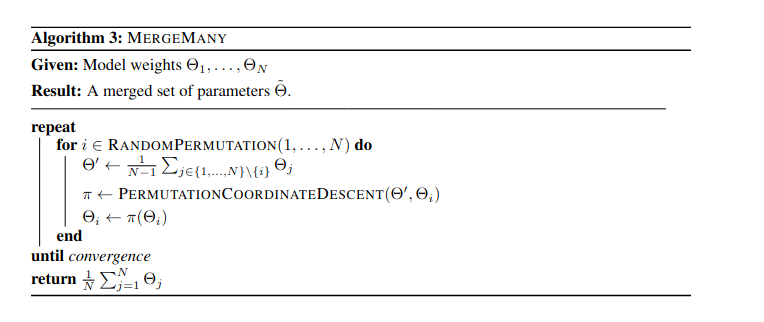

In [ ]:
#@title git merge many
def git_merge_many(models, runs=100, digit=4): 

  print(f'GIT MERGE OVER {len(models)} MODELS')
  for run in range(runs): 
    progress = False
        
    for i in np.random.permutation(list(range(len(models)))): 
      
      m_avg = average_multiple_model(models[:i] + models[i+1:])    
      new_model = git_merge(m_avg, models[i], silent=True)
      
      #cos similarity max=1, min=0
      old_cos = round(cosine_similarity(models[i], m_avg), digit)
      new_cos = round(cosine_similarity(new_model, m_avg), digit)
      
      #l2 norm
      #old_distance = round(l2_similarity(m_avg, models[i]), digit)
      #new_distance = round(l2_similarity(m_avg, new_model), digit)
      
      models[i] = new_model
      
      progress = progress or (old_cos < new_cos)
      print(f'sub_run:{run} |P(model{i})| similarity_gain: {round((new_cos - old_cos), digit)} | progress: {progress}')

    if not progress: 
      print('---------------------------')
      print('CONVERGENCE AT RUN : ', run, '\n')
      break
  return average_multiple_model(models)

    

<h1>Experiments</h1>

# small net over mnist, fashion
First test over a trained model, the SNet contains 4 dense layers with at most 50 neurons for each layer. 

In [ ]:
model_A_mnist, model_B_mnist = SNet(mnist_input_size, bias=True), SNet(mnist_input_size, bias=True)
model_A_fashion, model_B_fashion = SNet(mnist_input_size, bias=True), SNet(mnist_input_size, bias=True)

model_A_mnist = model_A_mnist.to(device)
model_B_mnist = model_B_mnist.to(device)
#--------------------------------------
model_A_fashion = model_A_fashion.to(device)
model_B_fashion = model_B_fashion.to(device)
#--------------------------------------

# consider other loss --> hinge Loss 
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 100

optimizer_A_mnist = optim.Adam(model_A_mnist.parameters())
optimizer_B_mnist = optim.Adam(model_B_mnist.parameters())
#--------------------------------------
optimizer_A_fashion = optim.Adam(model_A_fashion.parameters())
optimizer_B_fashion = optim.Adam(model_B_fashion.parameters())
#--------------------------------------

In [ ]:
train_target_small = [
    ('model_A_mnist', model_A_mnist, data_loaders['mnist']['train'], optimizer_A_mnist), 
    ('model_B_mnist', model_B_mnist, data_loaders['mnist']['train'], optimizer_B_mnist), 

    ('model_A_fashion', model_A_fashion, data_loaders['fashion']['train'], optimizer_A_fashion),
    ('model_B_fashion', model_B_fashion, data_loaders['fashion']['train'], optimizer_B_fashion), 
              ]

In [ ]:
result_loss_small = defaultdict(list)

for (name, model, loader, opt) in train_target_small: 
  scaler = GradScaler() #prevent gradient to underflow
  print(f'{name = }')
  for epoch in tqdm.tqdm(range(epochs)): 
    result_epoch = train_loop(loader, model, 
                              loss_fn, opt,
                              scaler,
                              print_score=False,
                              return_loss=True)
    result_loss_small[name].append(result_epoch)
  torch.save(model.state_dict(), f'SNet_{name}_Adam.pt')

In [ ]:
sub_path = path + '/SNet/'
model_A_mnist.load_state_dict(torch.load(sub_path + 'SNet_model_A_mnist_Adam.pt'), map_location=device)
model_B_mnist.load_state_dict(torch.load(sub_path + 'SNet_model_B_mnist_Adam.pt'), map_location=device)

model_A_fashion.load_state_dict(torch.load(sub_path + 'SNet_model_A_fashion_Adam.pt'), map_location=device)
model_B_fashion.load_state_dict(torch.load(sub_path + 'SNet_model_B_fashion_Adam.pt'), map_location=device)

<All keys matched successfully>

In [ ]:
#generic coef of parameters for interpolation 
coef_vector = np.linspace(start=0.0, stop=1.0, num=10)

### mnist

In [ ]:
test_loop(data_loaders['mnist'], model_A_mnist, loss_fn, test_set=True, device=device)
test_loop(data_loaders['mnist'], model_B_mnist, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 97.4%, Avg loss: 0.211897 

Eval on test: 
 Accuracy: 96.8%, Avg loss: 0.288618 



In [ ]:
permuted_B_mnist = git_merge(model_A_mnist, model_B_mnist, silent=False)
print('Permuted model performance: ')
test_loop(data_loaders['mnist'], permuted_B_mnist, loss_fn, test_set=True, device=device)

print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['mnist'], 
                                                loss_fn,
                                                model_A_mnist, model_B_mnist,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['mnist'],
                                            loss_fn,
                                            model_A_mnist, permuted_B_mnist, 
                                            coef_vector, device=device)

run:0 || P1; gain: 982.4390106535202
run:0 || P2; gain: 62.219292408888755
run:0 || P3; gain: 32.97991719567089
run:1 || P2; gain: 12.073492276879335
run:1 || P3; gain: 3.945149566709773
run:1 || P1; gain: 4.1647983228778
run:2 || P1; gain: 0.0
run:2 || P2; gain: 1.4966277913999022
run:2 || P3; gain: 0.0
run:3 || P2; gain: 0.0
run:3 || P3; gain: 0.0
run:3 || P1; gain: 0.0
---------------------------
stop progress at run :  3
Permuted model performance: 
Eval on test: 
 Accuracy: 80.4%, Avg loss: 1.592895 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.2119  | 97.360
   1  | 0.11 |   0.1778  | 96.730
   2  | 0.22 |   0.3666  | 90.280
   3  | 0.33 |   1.4956  | 61.480
   4  | 0.44 |   2.9797  | 33.100
   5  | 0.56 |   2.8354  | 36.210
   6  | 0.67 |   1.4445  | 64.420
   7  | 0.78 |   0.5008  | 87.980
   8  | 0.89 |   0.2354  | 96.050
   9  | 1.00 |   0.2886  | 96.820

evaluate interpoalitoin permuted parameters: 
index | coef | test 

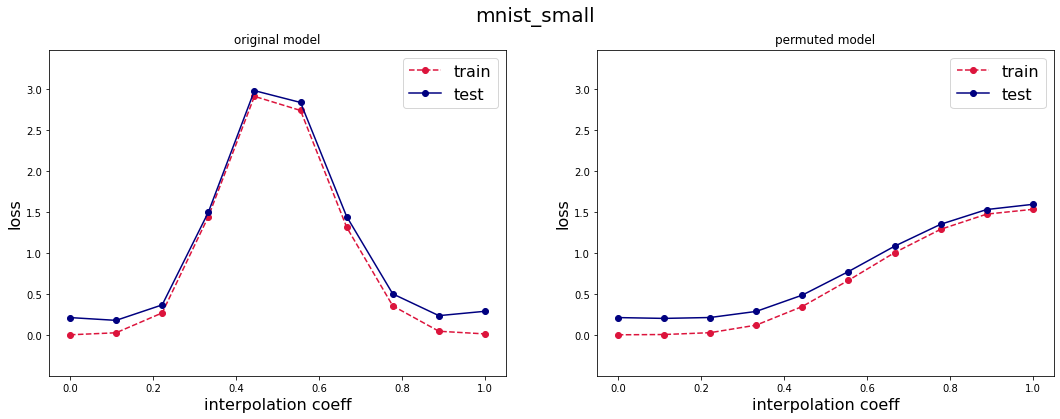

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'mnist_small')

Still, here we can check the first requirement for this method: a net should be wider than usual. Although the singular models achieve good performance over the Mnist dataset (accuracy = 97%, 96%), the permuted model gets an accuracy lower  than the original (80%) and the average loss increases.
\
In any case, the permuted model lies in a section where it's easier to interpolate the model, as we can see from the plot about the barrier, that disappears. The "only" problem here is the absence of a linear path.

### Fashion

In this second test we explored the same model over a more "complex" dataset, just to see if we get the same result as the mnist dataset. As we can see in the following plot, the result will be the same.  

In [ ]:
test_loop(data_loaders['fashion'], model_A_fashion, loss_fn, test_set=True, device=device)
test_loop(data_loaders['fashion'], model_B_fashion, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 87.5%, Avg loss: 0.597280 

Eval on test: 
 Accuracy: 87.2%, Avg loss: 0.594700 



In [ ]:
permuted_B_fashion = git_merge(model_A_fashion, model_B_fashion, silent=False)
print('Permuted model performance: ')
test_loop(data_loaders['fashion'], permuted_B_fashion, loss_fn, test_set=True, device=device)
print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

run:0 || P1; gain: 1205.5880126059856
run:0 || P2; gain: 59.790645862198915
run:0 || P3; gain: 44.40863471178899
run:1 || P2; gain: 12.767317736634823
run:1 || P1; gain: 1.932695494631389
run:1 || P3; gain: 1.374046672334174
run:2 || P2; gain: 1.1692502982442647
run:2 || P1; gain: 0.0
run:2 || P3; gain: 0.1414792623098151
run:3 || P3; gain: 0.0
run:3 || P2; gain: 0.0
run:3 || P1; gain: 0.0
---------------------------
stop progress at run :  3
Permuted model performance: 
Eval on test: 
 Accuracy: 61.3%, Avg loss: 1.223640 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.5973  | 87.460
   1  | 0.11 |   0.5918  | 84.050
   2  | 0.22 |   0.8763  | 75.130
   3  | 0.33 |   2.2341  | 48.510
   4  | 0.44 |   3.6950  | 30.140
   5  | 0.56 |   3.2877  | 26.910
   6  | 0.67 |   1.6323  | 51.320
   7  | 0.78 |   0.7657  | 75.770
   8  | 0.89 |   0.5261  | 85.320
   9  | 1.00 |   0.5947  | 87.220

evaluate interpoalitoin permuted parameters: 
in

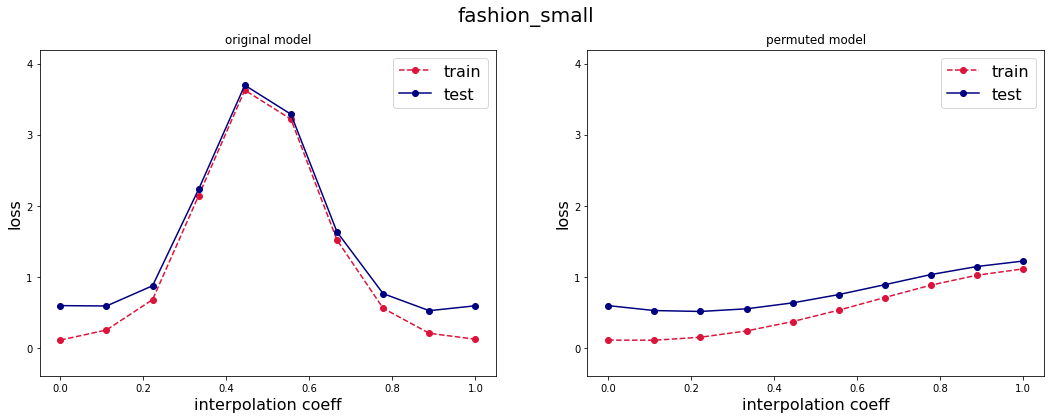

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'fashion_small')

# Wider net over mnist, fashion, cifar

As we have seen previously, a wider net shows better behaviour for permutation matching. Entezari et al theorize that it's because the hyper-parametrization of the loss creates a smoothed outline, that helps to create a linear path.

In [ ]:
model_A_mnist, model_B_mnist = MNet(mnist_input_size, bias=True), MNet(mnist_input_size, bias=True)
model_A_fashion, model_B_fashion = MNet(mnist_input_size, bias=True), MNet(mnist_input_size, bias=True)
model_A_cifar, model_B_cifar = MNet(cifar_input_size, bias=True), MNet(cifar_input_size, bias=True)

model_A_mnist = model_A_mnist.to(device)
model_B_mnist = model_B_mnist.to(device)
#--------------------------------------
model_A_fashion = model_A_fashion.to(device)
model_B_fashion = model_B_fashion.to(device)
#--------------------------------------
model_A_cifar = model_A_cifar.to(device)
model_B_cifar = model_B_cifar.to(device)

# consider other loss
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 100

optimizer_A_mnist = optim.Adam(model_A_mnist.parameters())
optimizer_B_mnist = optim.Adam(model_B_mnist.parameters())
#--------------------------------------
optimizer_A_fashion = optim.Adam(model_A_fashion.parameters())
optimizer_B_fashion = optim.Adam(model_B_fashion.parameters())
#--------------------------------------
optimizer_A_cifar = optim.Adam(model_A_cifar.parameters())
optimizer_B_cifar = optim.Adam(model_B_cifar.parameters())



In [ ]:
train_target_medium = [
    ('model_A_mnist', model_A_mnist, data_loaders['mnist']['train'], optimizer_A_mnist), 
    ('model_B_mnist', model_B_mnist, data_loaders['mnist']['train'], optimizer_B_mnist), 

    ('model_A_fashion', model_A_fashion, data_loaders['fashion']['train'], optimizer_A_fashion),
    ('model_B_fashion', model_B_fashion, data_loaders['fashion']['train'], optimizer_B_fashion), 

    ('model_A_cifar', model_A_cifar, data_loaders['cifar']['train'], optimizer_A_cifar),
    ('model_B_cifar', model_B_cifar, data_loaders['cifar']['train'], optimizer_B_cifar),
              ]

coef_vector = np.linspace(start=0.0, stop=1.0, num=10)

In [ ]:
result_loss_medium = defaultdict(list)

for (name, model, loader, opt) in train_target_medium: 
  scaler = GradScaler() #prevent gradient to underflow
  print(f'{name = }, medium net')
  for epoch in tqdm.tqdm(range(epochs)): 
    result_epoch = train_loop(loader, model, 
                              loss_fn, opt,
                              scaler,
                              print_score=False,
                              return_loss=True)
    result_loss_medium[name].append(result_epoch)
  torch.save(model.state_dict(), f'MNet_{name}_Adam.pt')

name = 'model_B_cifar', medium net


100%|██████████| 100/100 [20:09<00:00, 12.09s/it]


In [ ]:
subpath = path +"/MNet/"
model_A_mnist.load_state_dict(torch.load(subpath+'MNet_model_A_mnist_Adam.pt', map_location=device))
model_B_mnist.load_state_dict(torch.load(subpath+'MNet_model_B_mnist_Adam.pt', map_location=device))

model_A_fashion.load_state_dict(torch.load(subpath+'MNet_model_A_fashion_Adam.pt', map_location=device))
model_B_fashion.load_state_dict(torch.load(subpath+'MNet_model_B_fashion_Adam.pt', map_location=device))

model_A_cifar.load_state_dict(torch.load(subpath+'MNet_model_A_cifar_Adam.pt', map_location=device))
model_B_cifar.load_state_dict(torch.load(subpath+'MNet_model_B_cifar_Adam.pt', map_location=device))

<All keys matched successfully>

##mnist

In [ ]:
test_loop(data_loaders['mnist'], model_A_mnist, loss_fn, test_set=True, device=device)
test_loop(data_loaders['mnist'], model_B_mnist, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 98.6%, Avg loss: 0.212665 

Eval on test: 
 Accuracy: 98.6%, Avg loss: 0.218879 



In [ ]:
permuted_B_mnist = git_merge(model_A_mnist, model_B_mnist, silent=False)
print('Permuted model performance: ')
test_loop(data_loaders['mnist'], permuted_B_mnist, loss_fn, test_set=True, device=device)

print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['mnist'], 
                                                loss_fn,
                                                model_A_mnist, model_B_mnist,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['mnist'],
                                            loss_fn,
                                            model_A_mnist, permuted_B_mnist, 
                                            coef_vector, device=device)

run:0 || P3; gain: 451.0353301437199
run:0 || P1; gain: 3343.7767522898266
run:0 || P2; gain: 1195.192184372091
run:1 || P1; gain: 51.66090895612615
run:1 || P3; gain: 495.30973823547174
run:1 || P2; gain: 109.08458525749575
run:2 || P3; gain: 77.94914223344631
run:2 || P2; gain: 11.466581162332659
run:2 || P1; gain: 9.608738873261245
run:3 || P1; gain: 0.0
run:3 || P2; gain: 4.647542077784237
run:3 || P3; gain: 25.342510036724434
run:4 || P3; gain: 0.0
run:4 || P1; gain: 0.8972917726023297
run:4 || P2; gain: 2.4619396433827205
run:5 || P1; gain: 0.7327414368955942
run:5 || P2; gain: 0.17387695514480583
run:5 || P3; gain: 4.549831230157906
run:6 || P2; gain: 1.4881607094621359
run:6 || P1; gain: 0.3219292105641216
run:6 || P3; gain: 2.1880863537621735
run:7 || P3; gain: 0.0
run:7 || P1; gain: 0.0
run:7 || P2; gain: 0.0
---------------------------
stop progress at run :  7
Permuted model performance: 
Eval on test: 
 Accuracy: 98.5%, Avg loss: 0.101155 

evaluate interpolation original 

From the table printed above, we can see that the accuracy remains stable.
\
Indeed, the loss decreased, pointing to a better set of weights respect the original models.

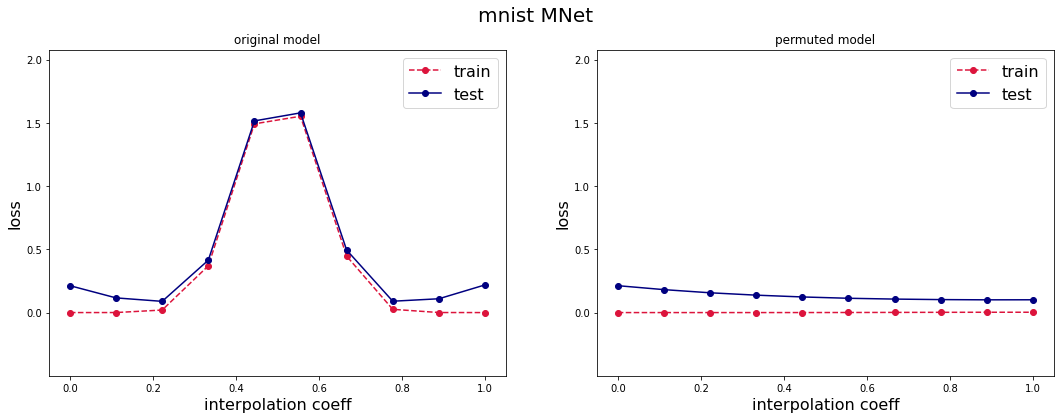

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'mnist MNet')

## fashion


Come back to the F_mnist dataset, the permuted net shows the same characteristics of the Mnist experiment. We lost a bit of accuracy (1.5%) but the path between the models results is still linear.

In [ ]:
test_loop(data_loaders['fashion'], model_A_fashion, loss_fn, test_set=True, device=device)
test_loop(data_loaders['fashion'], model_B_fashion, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 89.4%, Avg loss: 0.971641 

Eval on test: 
 Accuracy: 89.5%, Avg loss: 1.062084 



In [ ]:
permuted_B_fashion = git_merge(model_A_fashion, model_B_fashion, silent=True)
print('Permuted model performance: ')
test_loop(data_loaders['fashion'], permuted_B_fashion, loss_fn, test_set=True, device=device)
print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

Permuted model performance: 
Eval on test: 
 Accuracy: 88.0%, Avg loss: 0.442848 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.6183  | 87.430
   2  | 0.22 |   0.6788  | 79.390
   3  | 0.33 |   1.2071  | 58.560
   4  | 0.44 |   1.9680  | 29.040
   5  | 0.56 |   2.0848  | 30.510
   6  | 0.67 |   1.3961  | 57.450
   7  | 0.78 |   0.6810  | 80.920
   8  | 0.89 |   0.6803  | 88.030
   9  | 1.00 |   1.0621  | 89.540

evaluate interpoalitoin permuted parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.7900  | 89.670
   2  | 0.22 |   0.6554  | 89.650
   3  | 0.33 |   0.5623  | 89.640
   4  | 0.44 |   0.5027  | 89.140
   5  | 0.56 |   0.4663  | 88.850
   6  | 0.67 |   0.4484  | 88.710
   7  | 0.78 |   0.4417  | 88.260
   8  | 0.89 |   0.4414  | 87.940
   9  | 1.00 |   0.4428  | 87.990


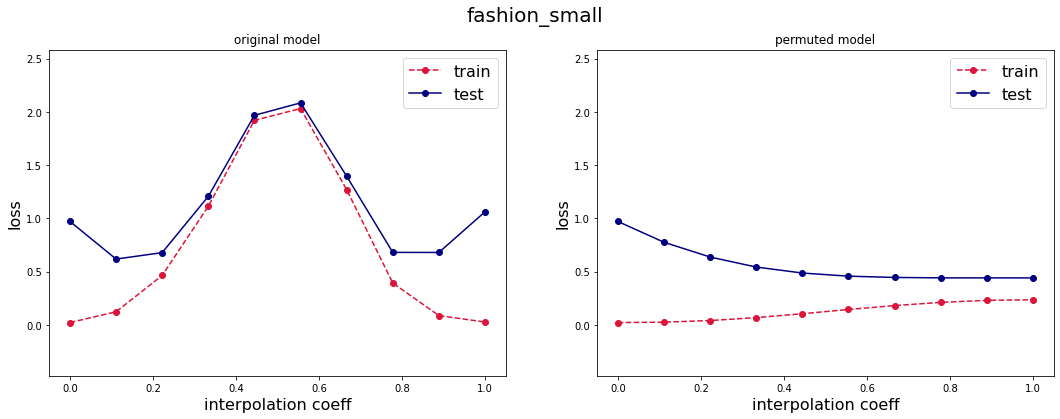

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'fashion MNet')

## cifar

Now it looks clear that the efficiency of a permuted model depends also on the task difficulty, so I choose to test the WiderNet also over the cifar10.
The phenomenon that we see is the same as the small net over an easy dataset: it's impossible for the weight_matching to find a set of permutations that create a linear path. The obstacle remains the profile of the loss function.

As in the previous test, the result of the permuted model interpolated with an original one is still better than the interpolation between the original models.

In [ ]:
test_loop(data_loaders['cifar'], model_A_cifar, loss_fn, test_set=True, device=device)
test_loop(data_loaders['cifar'], model_B_cifar, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 98.1%, Avg loss: 0.071412 

Eval on test: 
 Accuracy: 97.1%, Avg loss: 0.128897 



In [ ]:
permuted_B_fashion = git_merge(model_A_fashion, model_B_fashion, silent=True)
print('Permuted model performance: ')
test_loop(data_loaders['fashion'], permuted_B_fashion, loss_fn, test_set=True, device=device)
print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

Permuted model performance: 
Eval on test: 
 Accuracy: 86.6%, Avg loss: 0.426789 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.6183  | 87.430
   2  | 0.22 |   0.6788  | 79.390
   3  | 0.33 |   1.2071  | 58.560
   4  | 0.44 |   1.9680  | 29.040
   5  | 0.56 |   2.0848  | 30.510
   6  | 0.67 |   1.3961  | 57.450
   7  | 0.78 |   0.6810  | 80.920
   8  | 0.89 |   0.6803  | 88.030
   9  | 1.00 |   1.0621  | 89.540

evaluate interpoalitoin permuted parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.7650  | 89.690
   2  | 0.22 |   0.6224  | 89.530
   3  | 0.33 |   0.5301  | 89.320
   4  | 0.44 |   0.4740  | 88.880
   5  | 0.56 |   0.4430  | 88.340
   6  | 0.67 |   0.4295  | 87.750
   7  | 0.78 |   0.4254  | 87.270
   8  | 0.89 |   0.4254  | 86.930
   9  | 1.00 |   0.4268  | 86.610


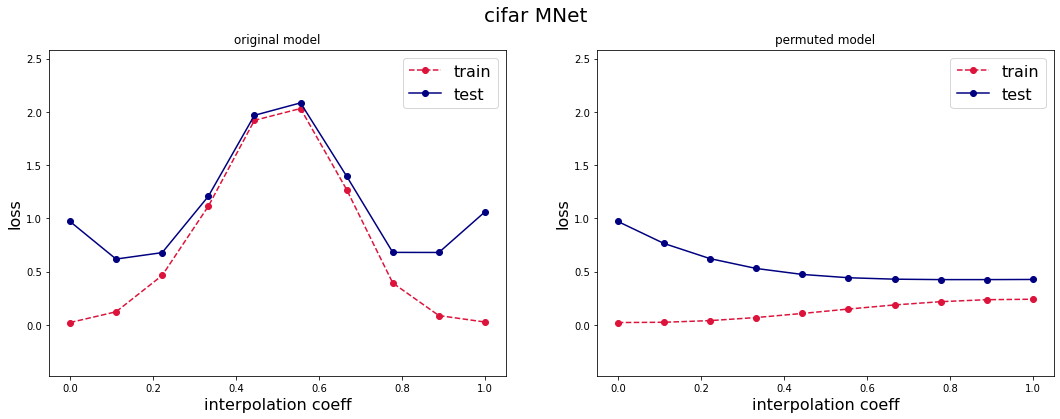

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'cifar MNet')

## cosine analysis 

The methodology of the paper has as goal the minimization of the distance between 2 models after the application of the permutation. For this reason, I also checked the cosine similarity and plotted everything as a heat-matrix. 
\
Here I create a matrix 4x4, where for each row i save the distance between a model and all the other versions.

In [ ]:
permuted_A_fashion = git_merge(model_B_fashion, model_A_fashion, silent=True) # reverse model

model_to_analyze = [
    model_A_fashion, 
    model_B_fashion, 

    permuted_A_fashion,
    permuted_B_fashion, 
]

similarity = np.eye(4)
for i, model in enumerate(model_to_analyze):
  for j, second_model in enumerate(model_to_analyze): 
    similarity[i,j] = cosine_similarity(model, second_model)

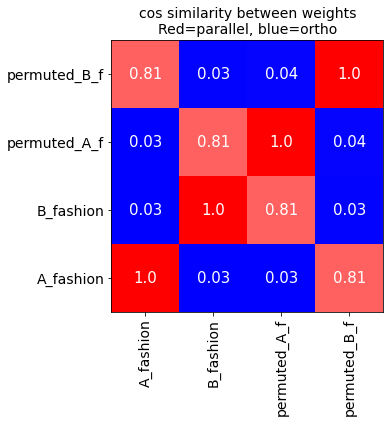

In [ ]:
label = ['A_fashion', 'B_fashion', 'permuted_A_f', 'permuted_B_f' ]

fig, ax = plt.subplots(figsize=(5, 5))
plt.title("cos similarity between weights\nRed=parallel, blue=ortho",fontsize=14)
im = ax.imshow(similarity ,cmap=plt.cm.bwr,origin="lower")
fig.patch.set_facecolor('white')
# add label 
plt.xticks(range(len(model_to_analyze)), label ,rotation = 90,fontsize=14)
plt.yticks(range(len(model_to_analyze)), label, fontsize=14)
# add text
for i in range(similarity.shape[0]):
    for j in range(similarity.shape[1]):
        text = ax.text(j, i, round(similarity[i, j], 2), fontsize=15, ha="center", va="center", color="w")

plt.show()


From this matrix we see a symmetry in the permutation. This symmetry will also be plotted in the next section as a barrier between the models.
\ 
As might be expected, on the matrix we find a main diagonal with maximum values(distance between a model and itself).
\
We also find an antidiagonal, matching permuted models with corresponding ones. 

## On the symmetry of permutation

In [ ]:
print ('original parameter, interpolation')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpolation permuted parameters  (p(B) --> A) : ')
eval_dict_permuted_A_over_B = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

print('\nevaluate interpolation permuted parameters (p(A) --> B): ')
eval_dict_permuted_B_over_A = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            permuted_A_fashion, model_B_fashion, 
                                            coef_vector, device=device)


original parameter, interpolation
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.6183  | 87.430
   2  | 0.22 |   0.6788  | 79.390
   3  | 0.33 |   1.2071  | 58.560
   4  | 0.44 |   1.9680  | 29.040
   5  | 0.56 |   2.0848  | 30.510
   6  | 0.67 |   1.3961  | 57.450
   7  | 0.78 |   0.6810  | 80.920
   8  | 0.89 |   0.6803  | 88.030
   9  | 1.00 |   1.0621  | 89.540

evaluate interpolation permuted parameters  (p(B) --> A) : 
index | coef | test loss | test_acc
   0  | 0.00 |   0.9716  | 89.390
   1  | 0.11 |   0.7650  | 89.690
   2  | 0.22 |   0.6224  | 89.530
   3  | 0.33 |   0.5301  | 89.320
   4  | 0.44 |   0.4740  | 88.880
   5  | 0.56 |   0.4430  | 88.340
   6  | 0.67 |   0.4295  | 87.750
   7  | 0.78 |   0.4254  | 87.270
   8  | 0.89 |   0.4254  | 86.930
   9  | 1.00 |   0.4268  | 86.610

evaluate interpolation permuted parameters (p(A) --> B): 
index | coef | test loss | test_acc
   0  | 0.00 |   0.4276  | 87.560
   1  | 0.11 |   0.4292 

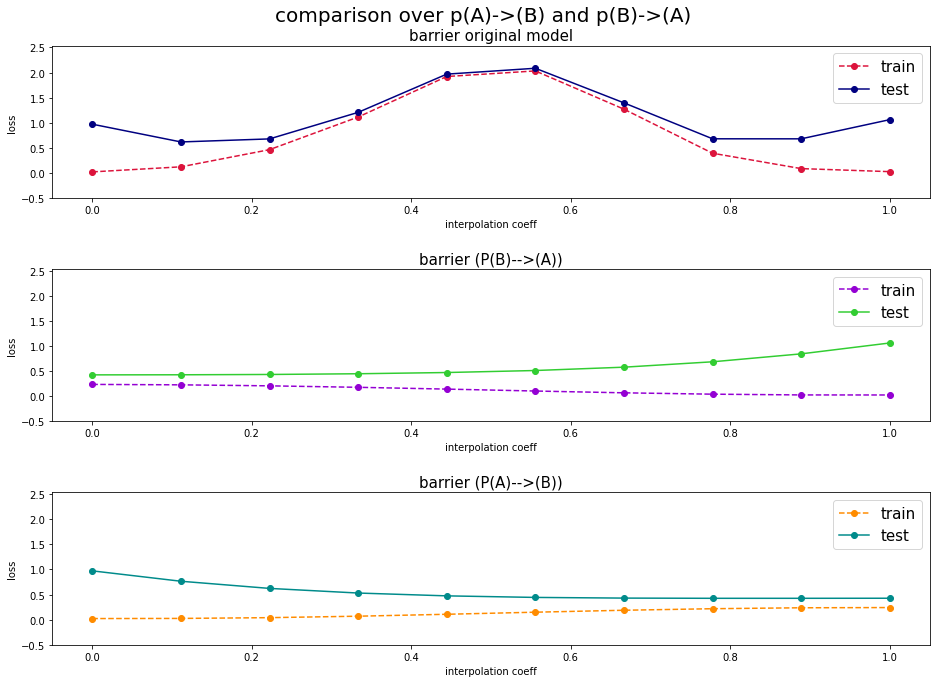

In [ ]:
max_lim = max(eval_dict_non_permuted['train']) 

fig, axs = plt.subplots(3, figsize=(14, 10))
fig.tight_layout(pad=5.0)
fig.suptitle('comparison over p(A)->(B) and p(B)->(A)', fontsize=20)
axs[1].legend(prop={'size': 15})


axs[0].set_title('barrier original model', fontsize=15)
axs[0].plot(coef_vector, eval_dict_non_permuted['train'],'--', marker='o', label='train', color='crimson')
axs[0].plot(coef_vector, eval_dict_non_permuted['test'], marker='o', label='test', color='navy')
axs[0].set_ylim([-0.5, max_lim+0.5])
axs[0].legend(prop={'size': 15})
axs[0].set_xlabel('interpolation coeff')
axs[0].set_ylabel('loss')

axs[1].set_title('barrier (P(B)-->(A))', fontsize=15)
axs[1].plot(coef_vector, eval_dict_permuted_B_over_A['train'], '--', label='train', marker='o', color='darkviolet')
axs[1].plot(coef_vector, eval_dict_permuted_B_over_A['test'], marker='o', label='test', color='limegreen')
axs[1].set_ylim([-0.5, max_lim+0.5])
axs[1].legend(prop={'size': 15})
axs[1].set_xlabel('interpolation coeff')
axs[1].set_ylabel('loss')

axs[2].set_title('barrier (P(A)-->(B))',  fontsize=15)
axs[2].plot(coef_vector, eval_dict_permuted_A_over_B['train'], '--', label='train', marker='o', color='darkorange')
axs[2].plot(coef_vector, eval_dict_permuted_A_over_B['test'], marker='o', label='test', color='darkcyan')
axs[2].set_ylim([-0.5, max_lim+0.5])
axs[2].legend(prop={'size': 15})
axs[2].set_xlabel('interpolation coeff')
axs[2].set_ylabel('loss')

plt.show()



As can be seen from the graphs above, it makes little difference which model you choose to permute, at least in this case. The barrier will still reduce

## 2d projection 

Creation of a Gram-Schimdt orthogonalization process.
\
The goal is to plot the weights on a 2D space and see the linear connectivity. 
\
\
To do this, i define a VectorSpace class that abstracts the procedure.
The procedure of sampling the loss landscape is pretty expensive. For this reason, I have saved a matrix (loss_grid.obj) that contains all the sample values. 
\ Load it for a fast 

In [ ]:
# procedure
class VectorSpace:

  def __init__(self, vec1, vec2, vec3): 
    self._calc_basis(vec1, vec2, vec3)

  def _calc_basis(self, vec1, vec2, vec3):
    self.v1 = vec1
    self.v2 = vec2
    self.basis1 = vec2 - vec1
    self.basis2 = vec3 - vec1
    self.basis1_normed = self.basis1 / np.sqrt(np.sum(self.basis1**2))
    self.basis2_normed = self.basis2 / np.sqrt(np.sum(self.basis2**2))
    self.scale_factor = np.sqrt(np.sum(self.basis1**2))


  def project(self, vec): # AKA vect2point ---> fix notation
    x = np.sum((vec - self.v1)*self.basis1_normed)/self.scale_factor
    y = np.sum((vec - self.v2)*self.basis2_normed)/self.scale_factor
    return x, y

  def convert_to_vect(self, x, y):
    return self.v1 + (self.basis1_normed * x * self.scale_factor) +\
            (self.basis2_normed * y * self.scale_factor)
#-----------------------------------------------------------

def deflat_params(flatten_vect, original_shape:dict):
  index = 0
  new_model_dict = {}
  for k, v in original_shape.items(): 
    if len(v)==1: 
      num_param = v[0]
      new_model_dict[k] = flatten_vect[index:index+num_param]
    else: 
      num_param = v[0]*v[1]
      temp = flatten_vect[index: num_param+index]
      new_model_dict[k] = temp.reshape(v)
    index += num_param  
  return new_model_dict


In [ ]:
x_axis = np.linspace(-0.5, 1.5, 20)
y_axis = np.linspace(-0.5, 1.5, 20)
loss_grid = np.zeros((len(x_axis), len(y_axis)))

p1 = detach_parameters(dict(model_A_mnist.named_parameters()))
p2 = detach_parameters(dict(model_B_mnist.named_parameters()))
p3 = detach_parameters(dict(permuted_B_mnist.named_parameters()))
model_dict_shape = {k: v.shape for k, v in p1.items()}

temp_model = MNet(mnist_input_size, bias=True)
temp_model.to(device)

v1 = np.concatenate([p1[k].reshape([-1]) for k in p1.keys()], axis=0)
v2 = np.concatenate([p2[k].reshape([-1]) for k in p1.keys()], axis=0)
v3 = np.concatenate([p3[k].reshape([-1]) for k in p1.keys()], axis=0)

vect_space = VectorSpace(v1, v2, v3)

In [ ]:
# sample landscape

for i, x in enumerate(x_axis): 
  for j, y in enumerate(y_axis): 
    flatten_param = vect_space.convert_to_vect(x, y)
    params = deflat_params(flatten_param, model_dict_shape)
    temp_model.load_state_dict(retach_parameters(params))
    _, test_loss = test_loop(data_loaders['mnist'], temp_model,
                             loss_fn, device,
                             test_set=False, print_score=False)
    loss_grid[i, j] = test_loss
    

file_reference = open('loss_grid.obj', 'wb')
pickle.dump(loss_grid, file_reference)
file_reference.close()

In [ ]:
#the loss_grid params require 30 min to be calc, better load it
file_reference = open(path+'/loss_grid.obj', 'rb')
loss_grid pickle.load(file_reference)
file_reference.close()

In [ ]:
log_loss_grid = np.log(loss_grid)

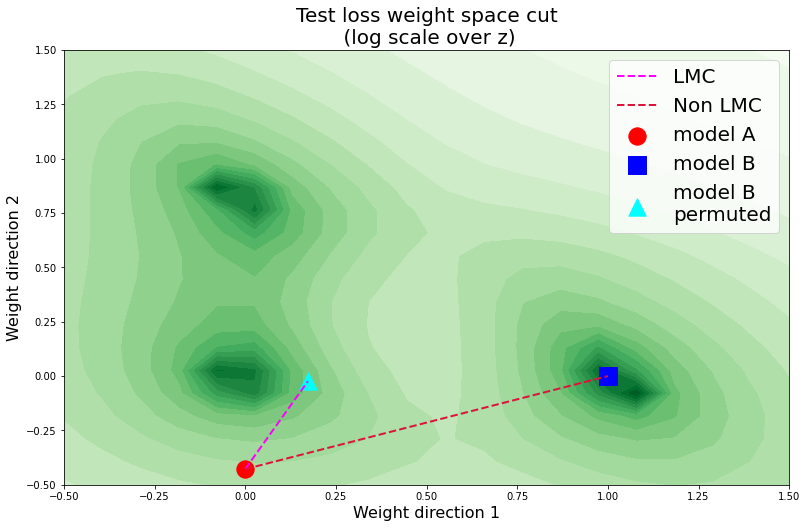

<Figure size 600x500 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
fig = plt.figure(figsize=(6, 5), dpi=100)
fig.patch.set_facecolor('white')

ax.set_title(f"Test loss weight space cut\n (log scale over z)", fontsize=20)

ax.contourf( x_axis,y_axis,log_loss_grid.T,
             cmap=plt.cm.Greens_r,
             levels=20)

x_m1,y_m1 = vect_space.project(v1)
ax.scatter([x_m1],[y_m1],marker="o",color="red",label="model A",s=300)

x_m2,y_m2 = vect_space.project(v2)
ax.scatter([x_m2],[y_m2],marker="s",color="blue",label="model B",s=300)

x_m2_perm,y_m2_perm = vect_space.project(v3)
ax.scatter([x_m2_perm],[y_m2_perm],marker="^",color="aqua",label="model B\npermuted",s=300)


ax.plot([x_m1,x_m2_perm],[y_m1,y_m2_perm],linewidth=2,linestyle="--",color="fuchsia",label="LMC")
ax.plot([x_m1,x_m2],[y_m1,y_m2],linewidth=2,linestyle="--",color="crimson",label="Non LMC")


ax.set_xlabel("Weight direction 1",fontsize = 16)
ax.set_ylabel("Weight direction 2",fontsize = 16)


ax.legend(fontsize=20,ncol=1)

plt.show()

Very cool part: the interpolation between the original <font color='red'>model A</font> and the <font color='2be6d0'>permuted model B</font> don't result in a linear path, but in a convex path. Indeed, moving closer to the permuted model we should see a reduction in the loss function


#depth net over Mnist, Fashion, cifar10

The last test about model architecture and merging procedure was done with a deep version of the small net. The set of non-linear transformations doesn't help the loss landscape to converge in a single basis profile. The 3 tests run over the same dataset and the procedures are the same as before. 

\
 
The only case in which we can consider the result as useful is with the Mnist dataset. 
\

In the F_mnist and in the Cifar10 the permuted model exhibits the worst performance in the original case. A possible reason for this is given in this section.
A possible reason about this is given in this [section](#scrollTo=zMgZpQ6ia4JU)

In [ ]:
model_A_mnist, model_B_mnist = DNet(mnist_input_size, bias=True), DNet(mnist_input_size, bias=True)
model_A_fashion, model_B_fashion = DNet(mnist_input_size, bias=True), DNet(mnist_input_size, bias=True)
model_A_cifar, model_B_cifar = DNet(cifar_input_size, bias=True), DNet(cifar_input_size, bias=True)

model_A_mnist = model_A_mnist.to(device)
model_B_mnist = model_B_mnist.to(device)
#--------------------------------------
model_A_fashion = model_A_fashion.to(device)
model_B_fashion = model_B_fashion.to(device)
#--------------------------------------
model_A_cifar = model_A_cifar.to(device)
model_B_cifar = model_B_cifar.to(device)

# consider other loss
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 100

optimizer_A_mnist = optim.Adam(model_A_mnist.parameters())
optimizer_B_mnist = optim.Adam(model_B_mnist.parameters())
#--------------------------------------
optimizer_A_fashion = optim.Adam(model_A_fashion.parameters())
optimizer_B_fashion = optim.Adam(model_B_fashion.parameters())
#--------------------------------------
optimizer_A_cifar = optim.Adam(model_A_cifar.parameters())
optimizer_B_cifar = optim.Adam(model_B_cifar.parameters())


In [ ]:
train_target_depth = [
    ('model_A_mnist', model_A_mnist, data_loaders['mnist']['train'], optimizer_A_mnist), 
    ('model_B_mnist', model_B_mnist, data_loaders['mnist']['train'], optimizer_B_mnist), 

    ('model_A_fashion', model_A_fashion, data_loaders['fashion']['train'], optimizer_A_fashion),
    ('model_B_fashion', model_B_fashion, data_loaders['fashion']['train'], optimizer_B_fashion), 

    ('model_A_cifar', model_A_cifar, data_loaders['cifar']['train'], optimizer_A_cifar),
    ('model_B_cifar', model_B_cifar, data_loaders['cifar']['train'], optimizer_B_cifar),
              ]

In [ ]:
result_loss_medium = defaultdict(list)

for (name, model, loader, opt) in train_target_depth: 
  scaler = GradScaler() #prevent gradient to underflow (only 16bits)
  print(f'{name = }, Depth net')
  for epoch in tqdm.tqdm(range(epochs)): 
    result_epoch = train_loop(loader, model, 
                              loss_fn, opt,
                              scaler,
                              print_score=False,
                              return_loss=True)
    result_loss_medium[name].append(result_epoch)
  torch.save(model.state_dict(), f'DNet_{name}_Adam.pt')

name = 'model_A_mnist', Depth net


100%|██████████| 100/100 [12:03<00:00,  7.24s/it]


name = 'model_B_mnist', Depth net


100%|██████████| 100/100 [12:00<00:00,  7.20s/it]


name = 'model_A_fashion', Depth net


100%|██████████| 100/100 [13:48<00:00,  8.28s/it]


name = 'model_B_fashion', Depth net


100%|██████████| 100/100 [15:00<00:00,  9.01s/it]


name = 'model_A_cifar', Depth net


100%|██████████| 100/100 [25:06<00:00, 15.06s/it]


name = 'model_B_cifar', Depth net


100%|██████████| 100/100 [19:38<00:00, 11.78s/it]


In [ ]:
subpath = path+"/DNet/"
model_A_mnist.load_state_dict(torch.load(subpath+'DNet_model_A_mnist_Adam.pt', map_location=device))
model_B_mnist.load_state_dict(torch.load(subpath+'DNet_model_B_mnist_Adam.pt', map_location=device))

model_A_fashion.load_state_dict(torch.load(subpath+'DNet_model_A_fashion_Adam.pt', map_location=device))
model_B_fashion.load_state_dict(torch.load(subpath+'DNet_model_B_fashion_Adam.pt',map_location=device))

model_A_cifar.load_state_dict(torch.load(subpath+'DNet_model_A_cifar_Adam.pt', map_location=device))
model_B_cifar.load_state_dict(torch.load(subpath+'DNet_model_B_cifar_Adam.pt', map_location=device))

<All keys matched successfully>

##mnist

In [ ]:
test_loop(data_loaders['mnist'], model_A_mnist, loss_fn, test_set=True, device=device)
test_loop(data_loaders['mnist'], model_B_mnist, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 97.7%, Avg loss: 0.140404 

Eval on test: 
 Accuracy: 89.5%, Avg loss: 0.317563 



In [ ]:
permuted_B_mnist = git_merge(model_A_mnist, model_B_mnist, silent=True)
print('Permuted model performance: ')
test_loop(data_loaders['mnist'], permuted_B_mnist, loss_fn, test_set=True, device=device)

print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['mnist'], 
                                                loss_fn,
                                                model_A_mnist, model_B_mnist,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['mnist'],
                                            loss_fn,
                                            model_A_mnist, permuted_B_mnist, 
                                            coef_vector, device=device)

Permuted model performance: 
Eval on test: 
 Accuracy: 79.6%, Avg loss: 0.809347 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.1404  | 97.730
   1  | 0.11 |   0.1509  | 97.500
   2  | 0.22 |   1.0886  | 94.480
   3  | 0.33 |   2.0188  | 48.760
   4  | 0.44 |   2.2768  | 10.280
   5  | 0.56 |   2.2253  | 23.890
   6  | 0.67 |   2.0027  | 33.140
   7  | 0.78 |   1.2603  | 86.460
   8  | 0.89 |   0.3410  | 89.450
   9  | 1.00 |   0.3176  | 89.510

evaluate interpoalitoin permuted parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   0.1404  | 97.730
   1  | 0.11 |   0.1165  | 97.720
   2  | 0.22 |   0.1049  | 97.700
   3  | 0.33 |   0.1106  | 97.640
   4  | 0.44 |   0.1485  | 97.590
   5  | 0.56 |   0.2539  | 97.380
   6  | 0.67 |   0.4448  | 96.910
   7  | 0.78 |   0.6686  | 95.020
   8  | 0.89 |   0.8051  | 75.910
   9  | 1.00 |   0.8093  | 79.560


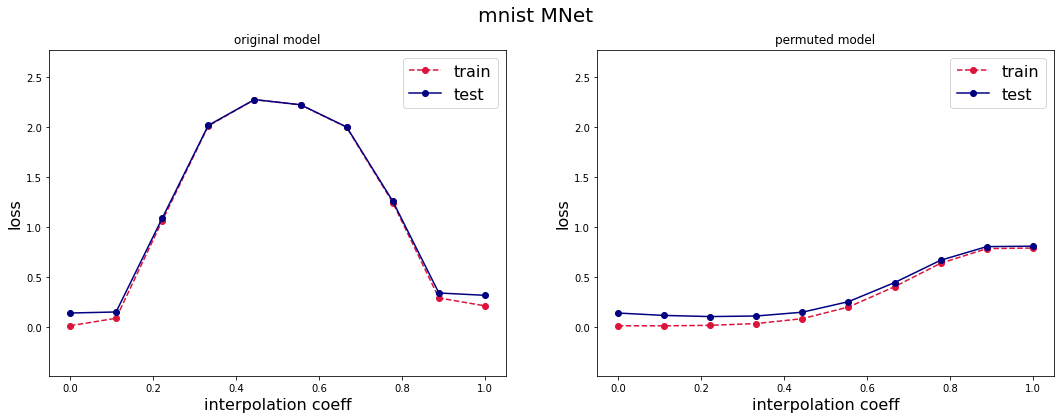

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'mnist MNet')

## fashion


In [ ]:
test_loop(data_loaders['fashion'], model_A_fashion, loss_fn, test_set=True, device=device)
test_loop(data_loaders['fashion'], model_B_fashion, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 71.2%, Avg loss: 1.043689 

Eval on test: 
 Accuracy: 79.0%, Avg loss: 0.963108 



In [ ]:
permuted_B_fashion = git_merge(model_A_fashion, model_B_fashion, silent=True)
print('Permuted model performance: ')
test_loop(data_loaders['fashion'], permuted_B_fashion, loss_fn, test_set=True, device=device)
print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

Permuted model performance: 
Eval on test: 
 Accuracy: 34.0%, Avg loss: 1.937755 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   1.0437  | 71.210
   1  | 0.11 |   0.8691  | 68.870
   2  | 0.22 |   1.4788  | 61.980
   3  | 0.33 |   2.1999  | 39.420
   4  | 0.44 |   2.3001  | 12.740
   5  | 0.56 |   2.2736  | 15.200
   6  | 0.67 |   2.0904  | 39.610
   7  | 0.78 |   1.3618  | 71.680
   8  | 0.89 |   0.8393  | 77.270
   9  | 1.00 |   0.9631  | 78.950

evaluate interpoalitoin permuted parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   1.0437  | 71.210
   1  | 0.11 |   0.9023  | 71.120
   2  | 0.22 |   0.8358  | 70.730
   3  | 0.33 |   0.8434  | 69.940
   4  | 0.44 |   0.9337  | 68.610
   5  | 0.56 |   1.1154  | 66.590
   6  | 0.67 |   1.3627  | 61.870
   7  | 0.78 |   1.6073  | 52.380
   8  | 0.89 |   1.8384  | 40.600
   9  | 1.00 |   1.9378  | 33.980


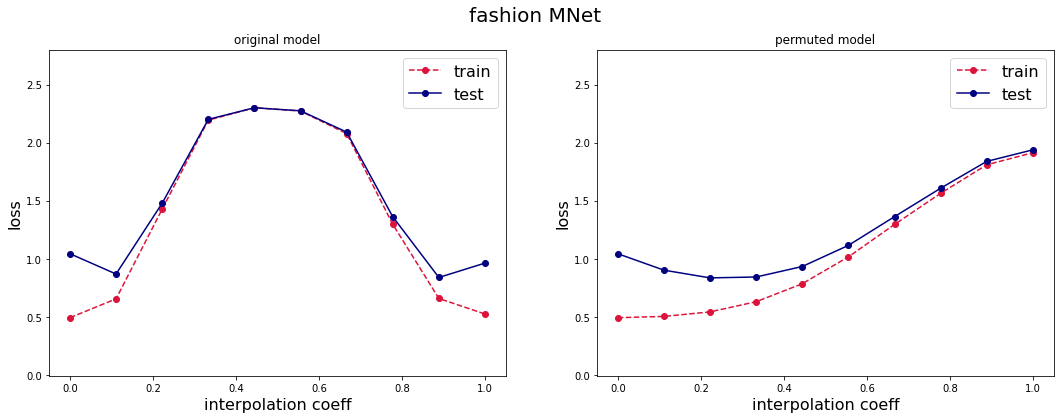

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'fashion MNet')

##cifar

In [ ]:
test_loop(data_loaders['cifar'], model_A_cifar, loss_fn, test_set=True, device=device)
test_loop(data_loaders['cifar'], model_B_cifar, loss_fn, test_set=True, device=device)

Eval on test: 
 Accuracy: 45.3%, Avg loss: 1.313538 

Eval on test: 
 Accuracy: 85.5%, Avg loss: 0.365249 



In [ ]:
permuted_B_fashion = git_merge(model_A_fashion, model_B_fashion, silent=True)
print('Permuted model performance: ')
test_loop(data_loaders['fashion'], permuted_B_fashion, loss_fn, test_set=True, device=device)
print('evaluate interpolation original parameters: ')
eval_dict_non_permuted = evaluate_interpolation(data_loaders['fashion'], 
                                                loss_fn,
                                                model_A_fashion, model_B_fashion,
                                                coef_vector, device=device)

print('\nevaluate interpoalitoin permuted parameters: ')
eval_dict_permuted = evaluate_interpolation(data_loaders['fashion'],
                                            loss_fn,
                                            model_A_fashion, permuted_B_fashion, 
                                            coef_vector, device=device)

Permuted model performance: 
Eval on test: 
 Accuracy: 34.2%, Avg loss: 1.998769 

evaluate interpolation original parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   1.0437  | 71.210
   1  | 0.11 |   0.8691  | 68.870
   2  | 0.22 |   1.4788  | 61.980
   3  | 0.33 |   2.1999  | 39.420
   4  | 0.44 |   2.3001  | 12.740
   5  | 0.56 |   2.2736  | 15.200
   6  | 0.67 |   2.0904  | 39.610
   7  | 0.78 |   1.3618  | 71.680
   8  | 0.89 |   0.8393  | 77.270
   9  | 1.00 |   0.9631  | 78.950

evaluate interpoalitoin permuted parameters: 
index | coef | test loss | test_acc
   0  | 0.00 |   1.0437  | 71.210
   1  | 0.11 |   0.9033  | 71.120
   2  | 0.22 |   0.8367  | 70.690
   3  | 0.33 |   0.8356  | 69.720
   4  | 0.44 |   0.9243  | 68.660
   5  | 0.56 |   1.1408  | 66.350
   6  | 0.67 |   1.4187  | 57.370
   7  | 0.78 |   1.6921  | 51.590
   8  | 0.89 |   1.9249  | 42.980
   9  | 1.00 |   1.9988  | 34.230


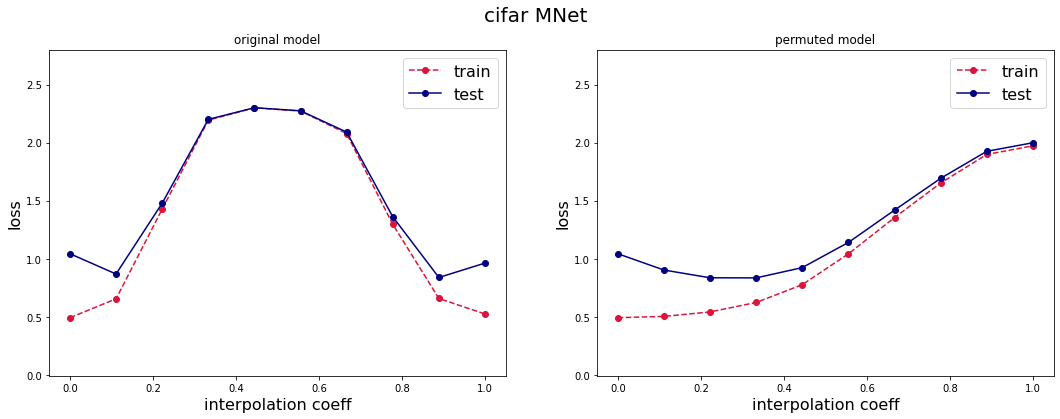

In [ ]:
plot_barrier(eval_dict_non_permuted, eval_dict_permuted, coef_vector, 'cifar MNet')

## possible cause of low performance over depth network : variance collapse

in [Repair, by jordan et. al 2023](https://arxiv.org/abs/2211.08403) it's show that the variance of activations progressively decays as we move deeper into the network, with the activations of later layers becoming nearly constant. As in the original paper, I measure the variance of each activation of each neuron, across a constant batch of training data.

The procedure for quantify the variance collapse:
- measure the variance across each neuron for each layer
- sum this variance --> $v\alpha, v1, v2$ for the interpolated net, and for the two original
- compute the ratio ($v\alpha) / ((v1 + v2)/2 $)
- report this in the final plot


In [ ]:
def measure_variance_across_activation(model, sample): #repair problem
  activation = {}

  def getActivation(name):
    def hook(mode, input, output): 
      activation[name] = output.detach()
    return hook 

  for name, module in model.named_children(): 
    hook = module.register_forward_hook(getActivation(name))
    out = model(sample)
    hook.remove()

  activation = {k: v.numpy() for k, v in activation.items()}
  var_for_layer = {k: np.sum(np.sum(np.var(v, axis=1))) for k, v in activation.items()}
  return var_for_layer


sample = next(iter(data_loaders['mnist']['train']))[0]

In [ ]:
var_model_A = measure_variance_across_activation(model_A_mnist, sample)
var_model_A

{'dense1': 2022.6581,
 'dense2': 3517.4548,
 'dense3': 33513.91,
 'dense4': 125708.3,
 'dense5': 271178.78,
 'dense6': 496056.66,
 'dense7': 336495.94,
 'dense8': 117268.164}

In [ ]:
var_model_B = measure_variance_across_activation(model_B_mnist, sample)
var_model_B

{'dense1': 2138.149,
 'dense2': 4075.8489,
 'dense3': 41715.38,
 'dense4': 194910.89,
 'dense5': 565542.5,
 'dense6': 903671.7,
 'dense7': 369039.34,
 'dense8': 172259.83}

In [ ]:
var_model_B_perm = measure_variance_across_activation(git_merge(model_A_mnist, model_B_mnist, silent=True), sample)
var_model_B_perm

{'dense1': 1623.1292,
 'dense2': 1861.0361,
 'dense3': 15333.227,
 'dense4': 44236.8,
 'dense5': 59791.76,
 'dense6': 47597.176,
 'dense7': 11345.734,
 'dense8': 3158.354}

In [ ]:
ratio = {}
for k in var_model_A.keys():
  ratio[k] = var_model_B_perm[k]/ ((var_model_A[k] + var_model_B[k])/2)
ratio

{'dense1': 0.7801991777577523,
 'dense2': 0.49017824221408074,
 'dense3': 0.40763981033401114,
 'dense4': 0.2759460600357862,
 'dense5': 0.14291919015741503,
 'dense6': 0.06800916039335132,
 'dense7': 0.03216206241998539,
 'dense8': 0.021817261224518873}

In [ ]:
ratio_list = [v for k, v in ratio.items()]
ratio_list

[0.7801991777577523,
 0.49017824221408074,
 0.40763981033401114,
 0.2759460600357862,
 0.14291919015741503,
 0.06800916039335132,
 0.03216206241998539,
 0.021817261224518873]

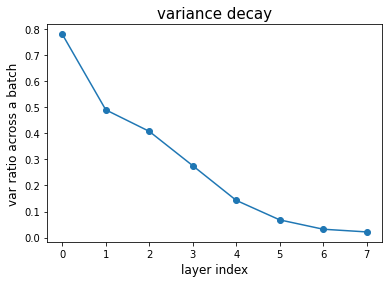

In [ ]:
plt.plot(ratio_list, marker='o')
plt.title('variance decay', fontsize=15)
plt.xlabel('layer index', fontsize=12)
plt.ylabel('var ratio across a batch', fontsize=12)
plt.show()

The obtained result here are consistent with the original plot from the [paper](https://arxiv.org/abs/2211.08403).

# Multiple Merge

## split dataset for unbalance sub-datasets
To test the capacity of merging different trainset (so different model) and simulate a federal learning setting, i choose to extract some unbalance subset form the original dataset, then train different model and try to interpolate after the permutation procedure

In [ ]:
len(experiment_data['MNIST']['train'])
# 60.000 sample, 6.000 for classes


60000

In [ ]:
# select index of each class, extract 800 sample
# lo [0] a fine istruzione serve perchè l'istruzione ritorna una tupla di len=1
sample_to_remove = 800
indeces_for_class_800_sample_MNIST_train = [
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 0))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 1))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 2))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 3))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 4))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 5))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 6))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 7))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 8))[0][:sample_to_remove],
    np.where((np.array(experiment_data['MNIST']['train'].targets) == 9))[0][:sample_to_remove],
]

total_indeces_used = np.concatenate(indeces_for_class_800_sample_MNIST_train, axis=0)
original_indeces = np.arange(0, len(experiment_data['MNIST']['train'])) 
remain_indeces = [i for i in original_indeces if i not in total_indeces_used]



In [ ]:
len(remain_indeces)

52000

In [ ]:
# shuffle the data for create 6 unbalance dataset, where each dataset has a maximum of 3 main classes

unbalance_data_idx = []
for i in range(6):
  unbalance_data_idx.append(
      [indeces_for_class_800_sample_MNIST_train[i] for i in 
      [random.randint(0, 9) for _ in range(3)]
      ]
  )
  unbalance_data_idx[i] = np.concatenate(unbalance_data_idx[i], axis=0)


In [ ]:
len(remain_indeces)//6

8666

In [ ]:
# Add remain sample from the original dataset
len_extra_data_for_dataset = len(remain_indeces)//6
shuffled_indices = np.random.permutation(remain_indeces)
split_indices = np.array_split(shuffled_indices, np.ceil(len(remain_indeces)/len_extra_data_for_dataset))
split_indices = np.array(split_indices)
unbalance_data_idx = [np.concatenate((unbalance_data_idx[i], split_indices[i])) for i in range(len(unbalance_data_idx))]

# create list od dataset
dataset_unbalance = [torch.utils.data.Subset(experiment_data['MNIST']['train'],
                                              unbalance_data_idx[i]) for i in range(len(unbalance_data_idx))]

<ipython-input-92-98d7a639060b>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  split_indices = np.array(split_indices)


In [ ]:
dataset_unbalance

{0: <torch.utils.data.dataset.Subset at 0x7f4b415be910>,
 1: <torch.utils.data.dataset.Subset at 0x7f4b41538fa0>,
 2: <torch.utils.data.dataset.Subset at 0x7f4b4a0bb0a0>,
 3: <torch.utils.data.dataset.Subset at 0x7f4b42069340>,
 4: <torch.utils.data.dataset.Subset at 0x7f4b4a0ac1f0>,
 5: <torch.utils.data.dataset.Subset at 0x7f4b4a0ac100>}

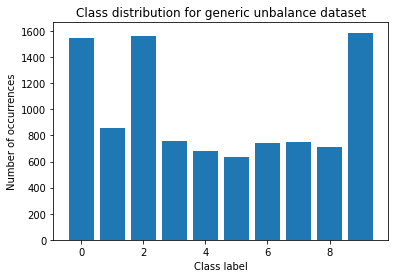

In [ ]:
#plot distribution of a random subdataset
class_counts = torch.zeros(10)
for example in dataset_unbalance[2]:
  class_counts[example[1]] += 1


plt.bar(range(10), class_counts)
plt.xlabel('Class label')
plt.ylabel('Number of occurrences')
plt.title('Class distribution for generic unbalance dataset')
plt.show()

In [ ]:
#create dataloader
data_loaders_unbalance = {i: DataLoader(dataset_unbalance[i], 
                                        batch_size=124, 
                                        shuffle=True) for i in range(len(dataset_unbalance))}

## Training 6 models default params


In [ ]:
#define 6 model
num_models = 6
epochs = 100 #100 by default, but low performance
models = [MNet(input_size=mnist_input_size, bias=True) for i in range(num_models)]
models = [models[i].to(device) for i in range(num_models)]
opts = [optim.Adam(models[i].parameters()) for i in range(num_models)]
loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
#train each model on a different dataset
for id in range(1): 
  for epoch in tqdm.tqdm(range(epochs)): 
    scaler = GradScaler() 
    train_loop(data_loaders_unbalance[id], models[id], 
               loss_fn, opts[id], 
               scaler,
               print_score=False, 
               return_loss=False)
  torch.save(models[id].state_dict(), f'MNet_unbalance_Adam_1e-4_mnist_{id}.pt')

In [ ]:
# or load the models
subpath = path+'/unbalance/mnist/adam_-4/'
for i in range(len(models)):
  models[i].load_state_dict(torch.load(subpath + f'MNet_unbalance_Adam_1e-4_mnist_{i}.pt'))

## Eval models over unbalance data

In [ ]:
[test_loop(data_loaders['mnist'], models[i], loss_fn, device, test_set=False) for i in range(num_models)];

Eval on train: 
 Accuracy: 95.5%, Avg loss: 0.308483 

Eval on train: 
 Accuracy: 95.9%, Avg loss: 0.257431 

Eval on train: 
 Accuracy: 95.8%, Avg loss: 0.280003 

Eval on train: 
 Accuracy: 95.9%, Avg loss: 0.280224 

Eval on train: 
 Accuracy: 95.7%, Avg loss: 0.302238 

Eval on train: 
 Accuracy: 95.8%, Avg loss: 0.270182 



In [ ]:
[test_loop(data_loaders['mnist'], models[i], loss_fn, device, test_set=True) for i in range(num_models)];

Eval on test: 
 Accuracy: 95.2%, Avg loss: 0.338789 

Eval on test: 
 Accuracy: 95.4%, Avg loss: 0.280903 

Eval on test: 
 Accuracy: 95.6%, Avg loss: 0.285759 

Eval on test: 
 Accuracy: 95.4%, Avg loss: 0.316844 

Eval on test: 
 Accuracy: 95.4%, Avg loss: 0.295238 

Eval on test: 
 Accuracy: 95.2%, Avg loss: 0.312307 



Average all the models return a ~50% less in the accuracy score

In [ ]:
test_loop(data_loaders['mnist'], average_multiple_model(models), loss_fn, device, test_set=False)

Eval on train: 
 Accuracy: 52.5%, Avg loss: 12.244119 



## multiple merge [paper style]


<h3>Problem :</h3>
The interpolation of several models strongly depends of the order of the model selected for the permutation. Sometimes i get a "good" test accuracy (92%) but more often i get a result near to 10% (random guess). The convergence comes after ~70 epochs but the loss grows up to infinity. For this reason, I have inserted a parameter that allows me to manually control the number of iterations. 

In [ ]:
model_merge_many = git_merge_many(copy.deepcopy(models), runs=1, digit=3)
test_loop(data_loaders['mnist'], model_merge_many, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], model_merge_many, loss_fn, device, test_set=False)

GIT MERGE OVER 6 MODELS
sub_run:0 |P(model3)| similarity_gain: 0.829 | progress: True
sub_run:0 |P(model5)| similarity_gain: 0.839 | progress: True
sub_run:0 |P(model4)| similarity_gain: 0.842 | progress: True
sub_run:0 |P(model1)| similarity_gain: 0.847 | progress: True
sub_run:0 |P(model0)| similarity_gain: 0.098 | progress: True
sub_run:0 |P(model2)| similarity_gain: 0.78 | progress: True
Eval on test: 
 Accuracy: 92.8%, Avg loss: 40.298571 

Eval on train: 
 Accuracy: 92.8%, Avg loss: 38.127755 



## multiple merge [permutation tree]

between models to be ineffective, since the paper itself presents a counterexample to the single basin assumptions, I tried a series of permutations between the trailed models, hoping that by thinking of the permutations as the nodes of a binary tree, I could arrive at the root with a model with knowledge of all the data and with the same accuracy.
My methods show a more stable behaviour but cannot compete with the result of the original paper (not the result that i get, i refer to the value that they get with their implementation) 


In [ ]:
m20 = git_merge(models[2], models[0], silent=True)
m21 = git_merge(models[2], models[1], silent=True) 
m34 = git_merge(models[3], models[4], silent=True) 
m35 = git_merge(models[3], models[5], silent=True)

In [ ]:
test_loop(data_loaders['mnist'], m20, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], m21, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], m34, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], m35, loss_fn, device, test_set=True)

Eval on test: 
 Accuracy: 94.7%, Avg loss: 0.282427 

Eval on test: 
 Accuracy: 94.8%, Avg loss: 0.248760 

Eval on test: 
 Accuracy: 94.7%, Avg loss: 0.283735 

Eval on test: 
 Accuracy: 91.0%, Avg loss: 0.400418 



In [ ]:
%%capture
m012 = git_merge(m20, m21)
m345 = git_merge(m34, m35)

In [ ]:
test_loop(data_loaders['mnist'], m012, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], m345, loss_fn, device, test_set=True)


Eval on test: 
 Accuracy: 94.3%, Avg loss: 0.266127 

Eval on test: 
 Accuracy: 93.6%, Avg loss: 0.296358 



In [ ]:
%%capture
mf = git_merge(m012, m345)

In [ ]:
test_loop(data_loaders['mnist'], mf, loss_fn, device, test_set=True)
test_loop(data_loaders['mnist'], mf, loss_fn, device, test_set=False)

Eval on test: 
 Accuracy: 91.5%, Avg loss: 0.341380 

Eval on train: 
 Accuracy: 91.6%, Avg loss: 0.331427 




Interestingly, the loss does not decrease, and the accuracy loses a few points, almost as if there is no linear path connecting all the subpoints.

However, I also noticed that the selection of the permutation order of the models is a key parameter in achieving convergence or non-convergence of the procedure.

<h3> Future work </h3>
A possible improvement to this approach might consider the distance between two models to select which ones to permute, hoping that similar models can be joined first, to reduce noise and disturbance in the procedure.